# Cross validating datasets

In [1]:
from ekorpkit import eKonf

if eKonf.is_colab():
    eKonf.mount_google_drive()
ws = eKonf.set_workspace(
    workspace="/workspace", 
    project="ekorpkit-book/exmaples", 
    task="esg", 
    log_level="INFO"
)
print("version:", ws.version)
print("project_dir:", ws.project_dir)

INFO:ekorpkit.base:Set environment variable EKORPKIT_DATA_ROOT=/workspace/data
INFO:ekorpkit.base:Set environment variable CACHED_PATH_CACHE_ROOT=/workspace/.cache/cached_path


version: 0.1.40.post0.dev57
project_dir: /workspace/projects/ekorpkit-book/exmaples
time: 944 ms (started: 2022-12-16 03:51:22 +00:00)


## Build an invalid dataset

In [3]:
rb_cfg = eKonf.compose('model/rubrix')
rb_cfg.auto.init = True
rb = eKonf.instantiate(rb_cfg)


INFO:ekorpkit.base:Loaded .env from /workspace/projects/ekorpkit-book/config/.env
INFO:ekorpkit.base:setting environment variable CACHED_PATH_CACHE_ROOT to /workspace/.cache/cached_path
INFO:ekorpkit.base:setting environment variable KMP_DUPLICATE_LIB_OK to TRUE
INFO:ekorpkit.base:Loaded .env from /workspace/projects/ekorpkit-book/config/.env
INFO:ekorpkit.base:Loaded .env from /workspace/projects/ekorpkit-book/config/.env
INFO:ekorpkit.base:Loaded .env from /workspace/projects/ekorpkit-book/config/.env


In [4]:
rb_category_dataset = rb.load("esg_category_prediction_check")

In [12]:
cols = ["text", "status", "annotation"]
invalid_dataset = rb_category_dataset[
    rb_category_dataset.status.isin(["Discarded", "Validated"])
][cols].rename(columns={"status": "labels"})
filename = "esg_invalid_data.parquet"
eKonf.save_data(invalid_dataset, filename, data_dir)

In [13]:
cfg = eKonf.compose("dataset=dataset_build")
cfg.name = "esg_invalid_kr"
cfg.data_dir = data_dir
cfg.data_file = filename
cfg.force.build = True
cfg.pipeline.split_sampling.stratify_on = "labels"
cfg.pipeline.split_sampling.random_state = 123
cfg.pipeline.split_sampling.test_size = 0.2
cfg.pipeline.split_sampling.dev_size = 0.2
cfg.pipeline.reset_index.drop_index = True
cfg.verbose = False
esg_invalid_ds = eKonf.instantiate(cfg)
esg_invalid_ds.persist()


INFO:ekorpkit.base:Applying pipe: functools.partial(<function load_dataframe at 0x7f2afb939a60>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function reset_index at 0x7f2afb932ca0>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function split_sampling at 0x7f2afb9328b0>)
INFO:ekorpkit.base:Using batcher with minibatch size: 2


apply len_bytes to num_bytes:   0%|          | 0/118 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 1


apply len_bytes to num_bytes:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 1


apply len_bytes to num_bytes:   0%|          | 0/75 [00:00<?, ?it/s]

In [14]:
esg_invalid_ds.data

,text,labels,annotation,split
0,■ 삼성SDI는 합작사 설립\n배터리 사업을 전개하고 있는 삼성SDI는 양극제 제조...,Discarded,None,train
1,26일 LG그룹은 전날부터 이틀간 진행된 계열사 이사회를 통해 총 177명의 승진 ...,Validated,G-지배구조,train
2,비어만 사장은 그럼에도 현대차가 배터리 자체 개발 및 생산기술 확보를 추진 중이라는...,Discarded,None,train
3,2019년 모바일TV ‘몰리브’를 출범하며 라이브 커머스 시장에 첫발을 내디딘 롯데...,Discarded,None,train
4,SNE리서치는 글로벌 배터리 수요가 2020년 139GWh에서 2030년 3254G...,Discarded,None,train
...,...,...,...,...
366,ICT업계 개발자 구인난 심화 속\n개발자 몸값이 치솟자 인문·사회계 비전공자들도 ...,Validated,S-고용,test
367,조직 재정비로 생겨난 여력은 미래 먹거리에 집중했다. 키워야 할 사업이라 판단되면 ...,Discarded,None,test
368,[헤럴드경제=양대근 기자] SK이노베이션은 최근 미국 특허심판원(PTAB)에 제기한...,Validated,G-기업윤리/불공정/소송,test
369,LG화학과 SK이노베이션 배터리를 장착한 친환경차가 포함됐다. LG화학은 파나소닉과...,Discarded,None,test


## Train an invalid classficiation model

In [30]:
ds_cfg = eKonf.compose("dataset")
ds_cfg.name = "esg_invalid_kr"
ds_cfg.data_dir = data_dir

overrides = [
    "+model/transformer=classification",
    "+model/transformer/pretrained=ekonelectra-base",
]
model_cfg = eKonf.compose("model/transformer=classification", overrides)
model_cfg.name = "esg_invalid"
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 3
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 32
model_cfg.config.eval_batch_size = 32
model_cfg.labels = ["Validated", "Discarded"]
model_cfg._method_ = ["train", "eval"]


## Prepare `esg_topics_improved` dataset

In [28]:
ds_cfg = eKonf.compose("dataset")
ds_cfg.name = "esg_topics_improved"
ds_cfg.data_dir = "/workspace/data/datasets/simple"
ds = eKonf.instantiate(ds_cfg)
cols = ["text", "labels"]
existing_data = ds.data[cols]
print(existing_data.shape)
filename = "esg_topics_existing.parquet"
eKonf.save_data(existing_data, filename, data_dir)


(11054, 2)


INFO:ekorpkit.base:Applying pipe: functools.partial(<function predict at 0x7f2afb932e50>)
INFO:ekorpkit.base:Calling train
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassifi

  0%|          | 0/236 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/16 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

acc,▁█▅
eval_loss,▁▁█
fn,▁█▅
fp,█▁▅
global_step,▁▅█
mcc,▁█▅
tn,▁█▅
tp,█▁▅
train_loss,▆▁█
acc,0.55
eval_loss,0.70578


INFO:ekorpkit.base:Calling eval


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Accuracy:  0.6666666666666666
Precison:  0.6767676767676769
Recall:  0.6666666666666666
F1 Score:  0.6658364466583645
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

   Discarded       0.62      0.74      0.68        35
   Validated       0.73      0.60      0.66        40

    accuracy                           0.67        75
   macro avg       0.67      0.67      0.67        75
weighted avg       0.68      0.67      0.67        75



  0%|          | 0/11054 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (731 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/356 [00:00<?, ?it/s]

,text,labels,pred_labels,raw_preds,pred_probs
0,"특히 , 벤처기업협회 는 조달청 이 혁신 조달시장 플랫폼 으로서 수요 기술 의 예고...",S-기업(공급망)동반성장/상생,Validated,"{'Discarded': 0.3987556591183646, 'Validated':...",0.601244
1,"( sk하이닉스 ) , 경쟁력 강화 및 고객 확보 를 위해 파운드리 사업부 분사 추...",G-지배구조,Discarded,"{'Discarded': 0.542485316149969, 'Validated': ...",0.542485
2,주주 활동 의 성공 지표 주주 활동 이 성공 했다고 하는 경우 기업 과 투자자 의 ...,G-지배구조,Validated,"{'Discarded': 0.4702285533016523, 'Validated':...",0.529771
3,이 들 은 자문 명목 으로만 1 인 당 수천만 원에서 많게는 수억 원을 받은 것으로...,G-기업윤리/불공정/소송,Validated,"{'Discarded': 0.4589559988355822, 'Validated':...",0.541044
4,대법 ' 증권 신고서 등 일부 잘못 있어도 증권사 책임 없어 '... 왜 ?\n증권...,G-기업윤리/불공정/소송,Validated,"{'Discarded': 0.4195118091144356, 'Validated':...",0.580488


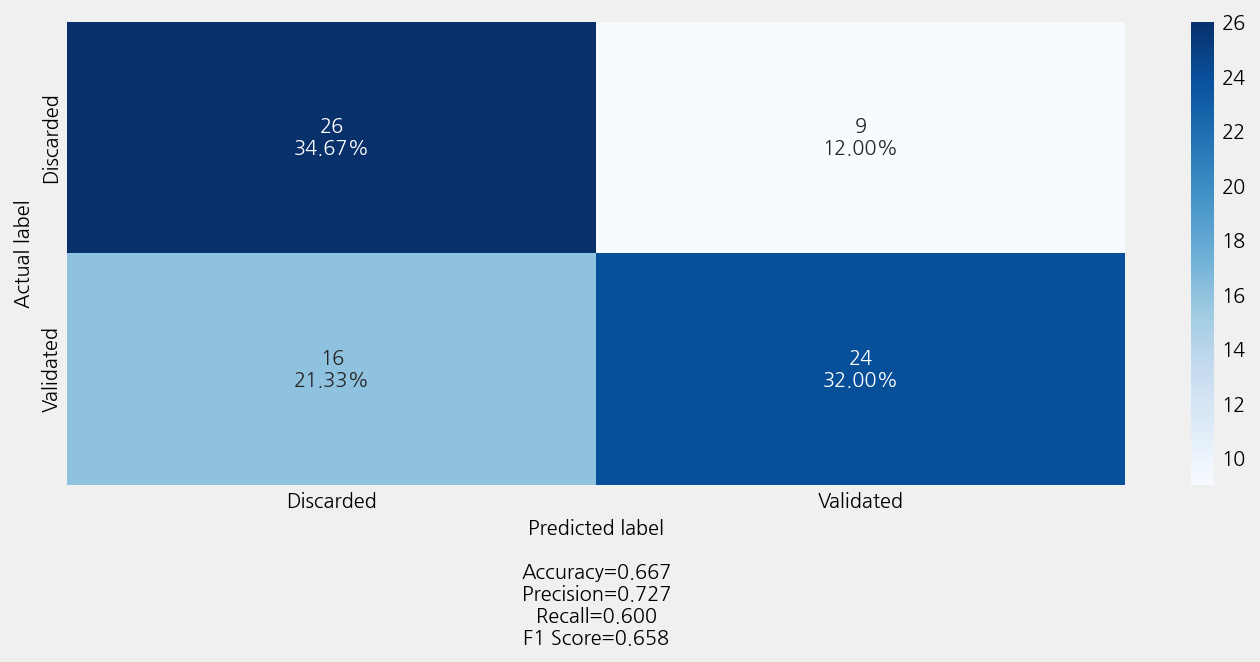

In [29]:
cfg = eKonf.compose(config_group="pipeline")
cfg.name = "esg_topics_valid"
cfg.data_dir = data_dir
cfg.data_file = filename
cfg._pipeline_ = ["predict"]
cfg.predict.model = model_cfg
cfg.predict.output_dir = data_dir
cfg.predict.output_file = f"{cfg.name}-preds.parquet"
cfg.num_workers = 1
topic_valid_preds_df = eKonf.instantiate(cfg)
topic_valid_preds_df.head()


In [33]:
valid_existing_data = topic_valid_preds_df[
    topic_valid_preds_df.pred_labels == "Validated"
][cols]
print(valid_existing_data.shape)


(6004, 2)


In [42]:
cols = ["text", "annotation"]
valid_dataset = rb_category_dataset[
    rb_category_dataset.status.isin(["Validated"])
][cols].rename(columns={"annotation": "labels"})
new_topic_dataset = eKonf.concat_data([valid_dataset, valid_existing_data])
print(new_topic_dataset.shape)
filename = "esg_rubrix_topic_data.parquet"
eKonf.save_data(new_topic_dataset, filename, data_dir)

(6202, 2)


## Build a valid topic dataset

In [20]:
filename = "esg_rubrix_topic_data.parquet"

cfg = eKonf.compose("dataset=dataset_build")
cfg.name = "esg_valid_topics_kr"
cfg.data_dir = data_dir
cfg.data_file = filename
cfg.force.build = True
cfg.pipeline.split_sampling.stratify_on = "labels"
cfg.pipeline.split_sampling.random_state = 12345
cfg.pipeline.split_sampling.test_size = 0.2
cfg.pipeline.split_sampling.dev_size = 0.2
cfg.pipeline.reset_index.drop_index = True
cfg.verbose = False
esg_valid_topic_ds = eKonf.instantiate(cfg)
esg_valid_topic_ds.persist()

INFO:ekorpkit.base:Applying pipe: functools.partial(<function load_dataframe at 0x7f29d12260d0>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function reset_index at 0x7f29d1225310>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function split_sampling at 0x7f29d1221ee0>)
INFO:ekorpkit.base:Using batcher with minibatch size: 18


apply len_bytes to num_bytes:   0%|          | 0/221 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 5


apply len_bytes to num_bytes:   0%|          | 0/199 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 6


apply len_bytes to num_bytes:   0%|          | 0/207 [00:00<?, ?it/s]

## Cross-validate `esg_valid_topics_kr` dataset

In [22]:
ds_cfg = eKonf.compose("dataset")
ds_cfg.name = "esg_valid_topics_kr"
ds_cfg.data_dir = data_dir

overrides=[
    '+model/transformer=classification',
    '+model/transformer/pretrained=ekonelectra-base',
]
model_cfg = eKonf.compose('model/transformer=classification', overrides)
model_cfg.name = "esg_valid_topics"
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 5
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 32
model_cfg.config.eval_batch_size = 32
model_cfg._method_ = []
model = eKonf.instantiate(model_cfg)

cv_preds = model.cross_val_predict(cv=5)
cv_preds = cv_preds.reset_index().rename(columns={"index": "id"})
eKonf.save_data(cv_preds, "esg_valid_topics_cv.parquet", data_dir)

INFO:ekorpkit.base:No method defined to call
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelect

  0%|          | 0/3968 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (712 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/1241 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/41 [00:00<?, ?it/s]

Training loss,█▆▄▄▃▄▃▂▂▁▂▂▁
acc,▁▆▇██
eval_loss,█▃▂▁▁
global_step,▁▂▂▂▃▃▃▄▅▅▅▆▆▆▇▇██
lr,█▇▇▆▆▅▅▄▃▃▂▂▁
mcc,▁▆▇██
train_loss,▄█▁▁▁
Training loss,0.08486
acc,0.78751
eval_loss,0.73779
global_step,650


  0%|          | 0/1241 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (731 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/41 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/3968 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (731 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/1241 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/41 [00:00<?, ?it/s]

Training loss,█▆▅▄▃▃▂▂▅▄▂▁▁
acc,▁▅▇██
eval_loss,█▄▂▁▁
global_step,▁▂▂▂▃▃▃▄▅▅▅▆▆▆▇▇██
lr,█▇▇▆▆▅▅▄▃▃▂▂▁
mcc,▁▅▇██
train_loss,█▆▂▅▁
Training loss,0.2548
acc,0.77039
eval_loss,0.80148
global_step,650


  0%|          | 0/1241 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/3969 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (691 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/1240 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/41 [00:00<?, ?it/s]

Training loss,█▅▅▅▃▂▅▂▂▁▂▁▂
acc,▁▅▇██
eval_loss,█▃▁▁▁
global_step,▁▂▂▂▃▃▃▄▅▅▅▆▆▆▇▇██
lr,█▇▇▆▆▅▅▄▃▃▂▂▁
mcc,▁▅▇██
train_loss,█▄▆▁▂
Training loss,0.46394
acc,0.78147
eval_loss,0.82527
global_step,650


  0%|          | 0/1240 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/3969 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (691 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/1240 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/41 [00:00<?, ?it/s]

Training loss,█▅▄▃▃▂▂▁▁▂▁▁▁
acc,▁▅▇██
eval_loss,█▄▁▁▁
global_step,▁▂▂▂▃▃▃▄▅▅▅▆▆▆▇▇██
lr,█▇▇▆▆▅▅▄▃▃▂▂▁
mcc,▁▅▇██
train_loss,█▄▃▄▁
Training loss,0.37927
acc,0.77644
eval_loss,0.81464
global_step,650


  0%|          | 0/1240 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/3969 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (691 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/1240 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/41 [00:00<?, ?it/s]

Training loss,█▆▄▅▄▂▃▂▂▂▁▁▁
acc,▁▅▇██
eval_loss,█▃▂▁▁
global_step,▁▂▂▂▃▃▃▄▅▅▅▆▆▆▇▇██
lr,█▇▇▆▆▅▅▄▃▃▂▂▁
mcc,▁▅▇██
train_loss,█▇▇▁▁
Training loss,0.32564
acc,0.78852
eval_loss,0.77292
global_step,650


  0%|          | 0/1240 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

In [25]:
records = rb.create_records_from_cv_preds(
    cv_preds,
)
records[0]


TextClassificationRecord(text="노동부 관계자 는 ' 삼성전자서비스 는 대기업 이 교육 · 훈련 능력 이 없는 협력업체 직원 들 의 훈련 을 지원 하기 위한 사업 인 ' 대기업 중소기업 상생 형 컨소시엄 ' 으로 운영비 · 훈련 비 등을 지원 받았다 ' 며 ' 위장 도 급 은 원청 과 협력업체 의 관계 를 종합적 으로 판단 하는 것이며 훈련 사업 과는 관련 이 없다 ' 고 말 했다 .", inputs={'text': "노동부 관계자 는 ' 삼성전자서비스 는 대기업 이 교육 · 훈련 능력 이 없는 협력업체 직원 들 의 훈련 을 지원 하기 위한 사업 인 ' 대기업 중소기업 상생 형 컨소시엄 ' 으로 운영비 · 훈련 비 등을 지원 받았다 ' 며 ' 위장 도 급 은 원청 과 협력업체 의 관계 를 종합적 으로 판단 하는 것이며 훈련 사업 과는 관련 이 없다 ' 고 말 했다 ."}, prediction=[('G-기업윤리/불공정/소송', 0.014792973524635432), ('E-환경영향', 0.01011066196727523), ('S-고용', 0.03259826738194377), ('G-지배구조', 0.006677545399021065), ('S-소비자', 0.017965496318325943), ('E-환경혁신', 0.012528997457076856), ('S-사회공헌', 0.07528742959158059), ('S-재해/안전관리', 0.01563472938407527), ('E-기후변화', 0.011562358220107061), ('S-기업(공급망)동반성장/상생', 0.802841540755959)], prediction_agent=None, annotation='S-고용', annotation_agent=None, multi_label=False, explanation=None, id=None, metadata={'id': 0, 'split': 'train'}, status='Validated', event_timestamp=N

In [26]:
# get records with potential label errors
records_with_label_error = rb.find_label_errors(records)
print(len(records_with_label_error))
records_with_label_error[0]

406


TextClassificationRecord(text='효과적 적 응 을 위해 기존 환경정보 의 관리 · 활용 은 필수적 이다 .\n구체적 인 자료 없이 불확실성 이 높은 상황 에서의 정책 입안 은 위험성 이 높으며 불필요 한 거래비용 을 야기 하기 때문이 다 .\n최근 런 칭 된 환경 과학 및 연구 를 공유 하는 새로운 플랫폼 인 unep 라이브 ( unep live ) 는 대중 과 정책 입안자 들 에게 네트워크 , 클라우드 컴퓨팅 , 대용량 데이터 , 향상 된 검색 기능 을 통해 광범위 한 데이터 를 제공 한다 .\n사용자 들 은 애플리케이션 , 멀티미디어 및 디지털 출판 도구 를 통해 unep 의 정보 뿐만 아니라 국가 · 지역적 자원 과 그 외 지식 및 데이터 로 접근 이 가능 하다 .', inputs={'text': '효과적 적 응 을 위해 기존 환경정보 의 관리 · 활용 은 필수적 이다 .\n구체적 인 자료 없이 불확실성 이 높은 상황 에서의 정책 입안 은 위험성 이 높으며 불필요 한 거래비용 을 야기 하기 때문이 다 .\n최근 런 칭 된 환경 과학 및 연구 를 공유 하는 새로운 플랫폼 인 unep 라이브 ( unep live ) 는 대중 과 정책 입안자 들 에게 네트워크 , 클라우드 컴퓨팅 , 대용량 데이터 , 향상 된 검색 기능 을 통해 광범위 한 데이터 를 제공 한다 .\n사용자 들 은 애플리케이션 , 멀티미디어 및 디지털 출판 도구 를 통해 unep 의 정보 뿐만 아니라 국가 · 지역적 자원 과 그 외 지식 및 데이터 로 접근 이 가능 하다 .'}, prediction=[('G-기업윤리/불공정/소송', 0.005687928438936715), ('E-환경영향', 0.0018410125274279446), ('S-고용', 0.0028207603159319233), ('G-지배구조', 0.003179272280394612), ('S-소비자', 0.9719110247106496), ('E-환경혁신', 0.003998241574432772), ('S

In [34]:
# remove rows from cv_preds that have label errors
cv_preds_new = cv_preds.copy()
for record in records_with_label_error:
    metadata = record.metadata
    cv_preds_new = cv_preds_new[cv_preds_new.id != metadata["id"]]
print(len(cv_preds_new))
filename = "esg_cv_topic_data.parquet"
eKonf.save_data(cv_preds_new, filename, data_dir)

5796


## Build cross-validated `esg_cv_topics_kr` dataset

In [35]:
filename = "esg_cv_topic_data.parquet"

cfg = eKonf.compose("dataset=dataset_build")
cfg.name = "esg_cv_topics_kr"
cfg.data_dir = data_dir
cfg.data_file = filename
cfg.force.build = True
cfg.pipeline.split_sampling.stratify_on = "labels"
cfg.pipeline.split_sampling.random_state = 12345
cfg.pipeline.split_sampling.test_size = 0.2
cfg.pipeline.split_sampling.dev_size = 0.2
cfg.pipeline.reset_index.drop_index = True
cfg.verbose = False
esg_valid_topic_ds = eKonf.instantiate(cfg)
esg_valid_topic_ds.persist()

INFO:ekorpkit.base:Applying pipe: functools.partial(<function load_dataframe at 0x7f29d12260d0>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function reset_index at 0x7f29d1225310>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function split_sampling at 0x7f29d1221ee0>)
INFO:ekorpkit.base:Using batcher with minibatch size: 17


apply len_bytes to num_bytes:   0%|          | 0/219 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 5


apply len_bytes to num_bytes:   0%|          | 0/186 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 6


apply len_bytes to num_bytes:   0%|          | 0/194 [00:00<?, ?it/s]

## Train and evaluate `esg_cv_topics_kr` dataset

INFO:ekorpkit.base:Calling train
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-disc

  0%|          | 0/3708 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (691 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/122 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/122 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/122 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/122 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/1160 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/38 [00:00<?, ?it/s]

Training loss,█▄▅▃▄▃▄▂▁▁▁▁
acc,▁▅▆▇█
eval_loss,█▃▂▁▁
global_step,▁▂▂▂▃▃▃▄▅▅▅▆▆▇▇██
lr,█▇▇▆▅▅▄▄▃▂▂▁
mcc,▁▅▆▇█
train_loss,█▄▄▂▁
Training loss,0.13852
acc,0.82866
eval_loss,0.71346
global_step,610


INFO:ekorpkit.base:Calling eval


  0%|          | 0/1160 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (712 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/38 [00:00<?, ?it/s]

Accuracy:  0.8456896551724138
Precison:  0.8492333903150788
Recall:  0.8456896551724138
F1 Score:  0.8465215619765862
Model Report: 
___________________________________________________
                  precision    recall  f1-score   support

          E-기후변화       0.89      0.83      0.86        47
          E-환경영향       0.84      0.79      0.82        62
          E-환경혁신       0.75      0.80      0.77        51
   G-기업윤리/불공정/소송       0.77      0.76      0.76       134
          G-지배구조       0.84      0.87      0.85       167
            S-고용       0.87      0.89      0.88       198
S-기업(공급망)동반성장/상생       0.68      0.84      0.75        49
          S-사회공헌       0.87      0.88      0.87       117
           S-소비자       0.93      0.85      0.89       286
       S-재해/안전관리       0.78      0.82      0.80        49

        accuracy                           0.85      1160
       macro avg       0.82      0.83      0.83      1160
    weighted avg       0.85      0.85      0.85      1160



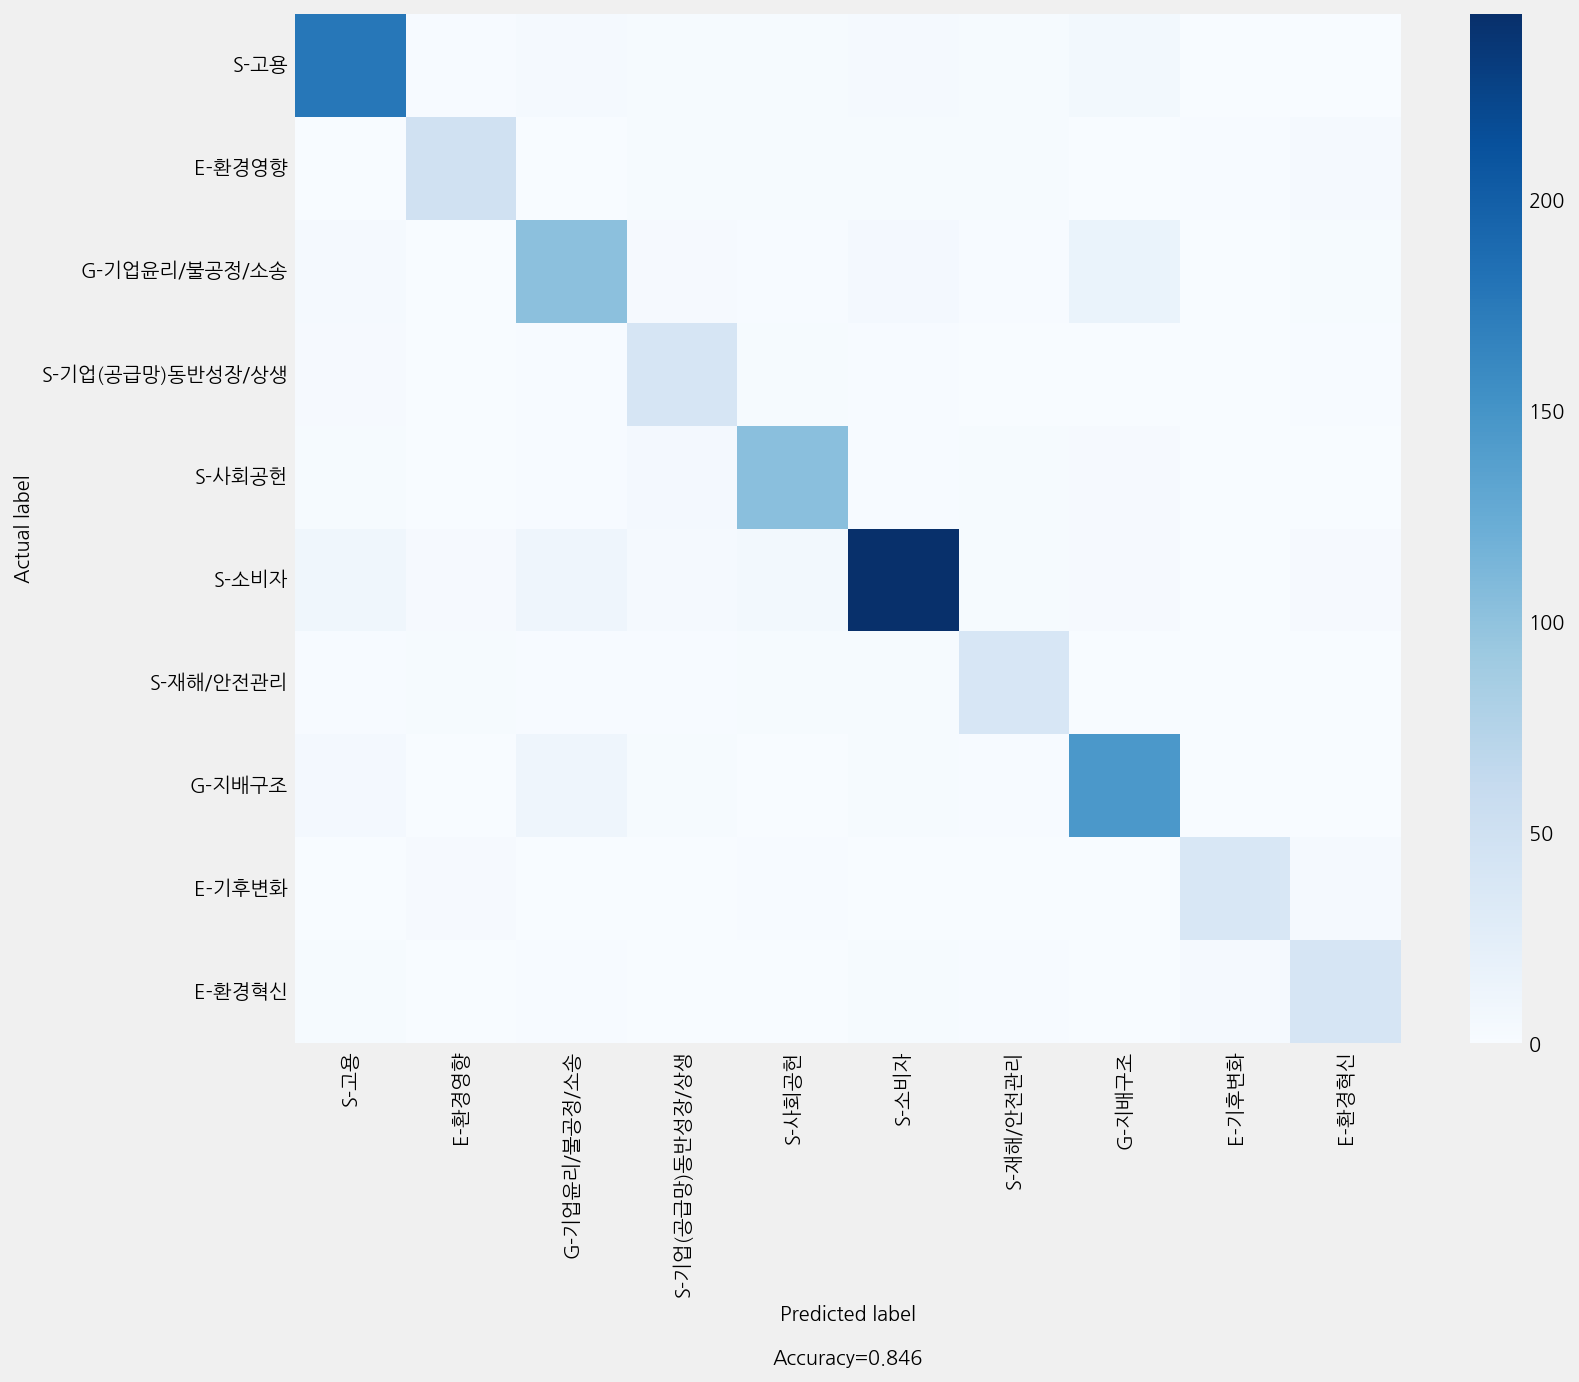

In [36]:
ds_cfg = eKonf.compose("dataset")
ds_cfg.name = "esg_cv_topics_kr"
ds_cfg.data_dir = data_dir

overrides=[
    '+model/transformer=classification',
    '+model/transformer/pretrained=ekonelectra-base',
]
model_cfg = eKonf.compose('model/transformer=classification', overrides)
model_cfg.name = "esg_cv_topics"
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 5
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 32
model_cfg.config.eval_batch_size = 32
model_cfg._method_ = ['train', 'eval']
model_cfg.model.eval.visualize.plot.confusion_matrix.include_values = False
model_cfg.model.eval.visualize.plot.confusion_matrix.include_percentages = False
model_cfg.model.eval.visualize.plot.figure.figsize = (12,10)
model = eKonf.instantiate(model_cfg)

## Prepare `esg_polarity_kr` dataset

In [37]:
ds_cfg = eKonf.compose("dataset")
ds_cfg.name = 'esg_polarity_kr'
ds_cfg.data_dir = data_dir
cols = ["text", "labels"]
ds = eKonf.instantiate(ds_cfg)
existing_polarity_data = ds.data[cols]
print(existing_polarity_data.shape)
filename = "esg_polarity_existing.parquet"
eKonf.save_data(existing_polarity_data, filename, data_dir)


(13616, 2)


## Build a valid polarity dataset

In [38]:
overrides = [
    "+model/transformer=classification",
    "+model/transformer/pretrained=ekonelectra-base",
]
model_cfg = eKonf.compose("model/transformer=classification", overrides)
model_cfg.name = "esg_invalid"
model_cfg.verbose = False
model_cfg._method_ = []


cfg = eKonf.compose(config_group="pipeline")
cfg.name = "esg_polarity_valid"
cfg.data_dir = data_dir
cfg.data_file = filename
cfg._pipeline_ = ["predict"]
cfg.predict.model = model_cfg
cfg.predict.output_dir = data_dir
cfg.predict.output_file = f"{cfg.name}-preds.parquet"
cfg.num_workers = 1
polarity_valid_preds_df = eKonf.instantiate(cfg)
polarity_valid_preds_df.head()


INFO:ekorpkit.base:Applying pipe: functools.partial(<function predict at 0x7f29d12254c0>)
INFO:ekorpkit.base:No method defined to call


  0%|          | 0/13616 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/432 [00:00<?, ?it/s]

,text,labels,pred_labels,raw_preds,pred_probs
0,헌법재판소는 먼저 고발권 행사의 재량성에 대해서는 공정거래법은 제71조에서 '......,Negative,Validated,"{'Discarded': 0.34311446903531895, 'Validated'...",0.656886
1,"특히, 그룹내 업종도 다르고 재무구조도 다른 계열사들이 그룹으로 묶여지는 특수한 지...",Neutral,Validated,"{'Discarded': 0.4446329014792689, 'Validated':...",0.555367
2,"2018년 신규 취업자수는 36만명 증가하고, 전체 취업자 증가율은 1.4%로 20...",Neutral,Discarded,"{'Discarded': 0.6374659019661213, 'Validated':...",0.637466
3,앞서 분석한 대로 5월엔 펀더멘털 개선과 위험 요인들이 h지수의 방향을 좌우할 것이...,Neutral,Discarded,"{'Discarded': 0.6180178427067431, 'Validated':...",0.618018
4,재생에너지의 성장 속도는 향후 10년 안에 세계 주요 지역의 전통 에너지원 (con...,Positive,Validated,"{'Discarded': 0.4631067621441408, 'Validated':...",0.536893


In [39]:
valid_existing_topic_data = polarity_valid_preds_df[
    polarity_valid_preds_df.pred_labels == "Validated"
][cols]
print(valid_existing_topic_data.shape)
filename = "esg_valid_polarity_data.parquet"
eKonf.save_data(valid_existing_topic_data, filename, data_dir)

(9086, 2)


In [7]:
cfg = eKonf.compose("dataset=dataset_build")
cfg.name = "esg_valid_polarity_kr"
cfg.data_dir = data_dir
cfg.data_file = filename
cfg.force.build = True
cfg.pipeline.split_sampling.stratify_on = "labels"
cfg.pipeline.split_sampling.random_state = 12345
cfg.pipeline.split_sampling.test_size = 0.2
cfg.pipeline.split_sampling.dev_size = 0.2
cfg.pipeline.reset_index.drop_index = True
cfg.verbose = False
esg_valid_topic_ds = eKonf.instantiate(cfg)
esg_valid_topic_ds.persist()

INFO:ekorpkit.base:Applying pipe: functools.partial(<function load_dataframe at 0x7f29d12260d0>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function reset_index at 0x7f29d1225310>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function split_sampling at 0x7f29d1221ee0>)
INFO:ekorpkit.base:Using batcher with minibatch size: 26


apply len_bytes to num_bytes:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 7


apply len_bytes to num_bytes:   0%|          | 0/208 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 8


apply len_bytes to num_bytes:   0%|          | 0/228 [00:00<?, ?it/s]

## Cross-validate `esg_polarity_kr` dataset

In [40]:
ds_cfg = eKonf.compose("dataset")
ds_cfg.name = "esg_valid_polarity_kr"
ds_cfg.data_dir = data_dir

overrides=[
    '+model/transformer=classification',
    '+model/transformer/pretrained=ekonelectra-base',
]
model_cfg = eKonf.compose('model/transformer=classification', overrides)
model_cfg.name = "esg_valid_polarity"
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 3
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 32
model_cfg.config.eval_batch_size = 32
model_cfg._method_ = []
model = eKonf.instantiate(model_cfg)

cv_preds = model.cross_val_predict(cv=5)
cv_preds = cv_preds.reset_index().rename(columns={"index": "id"})
eKonf.save_data(cv_preds, "esg_valid_polarity_cv.parquet", data_dir)

INFO:ekorpkit.base:No method defined to call
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelect

  0%|          | 0/5814 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/1818 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Training loss,█▄▆▆▅▄▄▅▆▁
acc,▁▅█
eval_loss,▄▁█
global_step,▁▂▂▃▃▄▅▅▅▆▇▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,█▁▃
train_loss,▅█▁
Training loss,0.19466
acc,0.68913
eval_loss,0.7345
global_step,549


  0%|          | 0/1818 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/5815 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/1817 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Training loss,██▆▅▅▄▄▃▁▃
acc,▁█▅
eval_loss,█▁▆
global_step,▁▂▂▃▃▄▅▅▅▆▇▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁▇█
train_loss,█▅▁
Training loss,0.4331
acc,0.69807
eval_loss,0.68063
global_step,549


  0%|          | 0/1817 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/57 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/5815 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/1817 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Training loss,▇▇█▂▁▄▃▁▂▃
acc,▁▇█
eval_loss,▇▁█
global_step,▁▂▂▃▃▄▅▅▅▆▇▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁▆█
train_loss,█▂▁
Training loss,0.51426
acc,0.70495
eval_loss,0.67766
global_step,549


  0%|          | 0/1817 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/5815 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/182 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/182 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/1817 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/58 [00:00<?, ?it/s]

Training loss,█▇▅▅▄▃▄▁▁▃
acc,▁█▂
eval_loss,▄▁█
global_step,▁▂▂▃▃▄▅▅▅▆▇▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁█▁
train_loss,█▆▁
Training loss,0.44572
acc,0.69395
eval_loss,0.70146
global_step,546


  0%|          | 0/1817 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-discriminator and are newly initializ

  0%|          | 0/5815 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/1817 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

Training loss,█▇▅▆▆▄▄▂▂▁
acc,▁█▆
eval_loss,▁▁█
global_step,▁▂▂▃▃▄▅▅▅▆▇▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁██
train_loss,▅█▁
Training loss,0.20041
acc,0.69876
eval_loss,0.72059
global_step,549


  0%|          | 0/1817 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [41]:
records = rb.create_records_from_cv_preds(
    cv_preds,
)
# get records with potential label errors
records_with_label_error = rb.find_label_errors(records)
print(len(records_with_label_error))
records_with_label_error[0]

1251


TextClassificationRecord(text='더 느린 속도의 공 격자가 양심적인 체인을 따라잡을 가능성은 후속 블록이 추가될 때마다 지수함수적으로 감소한다는 점을 뒤에서 입증하기로 한다\n가속하는 하드웨어 스피트와 장기적으로 변동하는 이익에 대응하기 위해 작업 증명 산출의 난이도는 1시간마다 블록 수를 이정한 평균치를 유지하는 것을 목표로 하는 평균 이동에 의해 결정된다\n블록 산출 속도가 빠를수록 난이도가 증가한다\n네트워크(network)나카 모토가 생각한 네트워크 실행 순서는 다음과 같다 23) 새로운 거래는 전체 노드들에게 송신된다\n각 노드가 새로운 거래를 블록에 반영한다', inputs={'text': '더 느린 속도의 공 격자가 양심적인 체인을 따라잡을 가능성은 후속 블록이 추가될 때마다 지수함수적으로 감소한다는 점을 뒤에서 입증하기로 한다\n가속하는 하드웨어 스피트와 장기적으로 변동하는 이익에 대응하기 위해 작업 증명 산출의 난이도는 1시간마다 블록 수를 이정한 평균치를 유지하는 것을 목표로 하는 평균 이동에 의해 결정된다\n블록 산출 속도가 빠를수록 난이도가 증가한다\n네트워크(network)나카 모토가 생각한 네트워크 실행 순서는 다음과 같다 23) 새로운 거래는 전체 노드들에게 송신된다\n각 노드가 새로운 거래를 블록에 반영한다'}, prediction=[('Positive', 0.02792251281400827), ('Neutral', 0.9533914708501714), ('Negative', 0.018686016335820517)], prediction_agent=None, annotation='Positive', annotation_agent=None, multi_label=False, explanation=None, id=None, metadata={'id': 1041, 'split': 'train', 'label_error_candidate': 0}, status='Validated', event_timestamp=No

In [42]:
# remove rows from cv_preds that have label errors
cv_preds_new = cv_preds.copy()
for record in records_with_label_error:
    metadata = record.metadata
    cv_preds_new = cv_preds_new[cv_preds_new.id != metadata["id"]]
print(len(cv_preds_new))
filename = "esg_cv_polarity_data.parquet"
eKonf.save_data(cv_preds_new, filename, data_dir)

7835


## Build cross-validated `esg_cv_polarity_kr` dataset

In [43]:
filename = "esg_cv_polarity_data.parquet"

cfg = eKonf.compose("dataset=dataset_build")
cfg.name = "esg_cv_polarity_kr"
cfg.data_dir = data_dir
cfg.data_file = filename
cfg.force.build = True
cfg.pipeline.split_sampling.stratify_on = "labels"
cfg.pipeline.split_sampling.random_state = 12345
cfg.pipeline.split_sampling.test_size = 0.2
cfg.pipeline.split_sampling.dev_size = 0.2
cfg.pipeline.reset_index.drop_index = True
cfg.verbose = False
esg_cv_polarity_ds = eKonf.instantiate(cfg)
esg_cv_polarity_ds.persist()

INFO:ekorpkit.base:Applying pipe: functools.partial(<function load_dataframe at 0x7f29d12260d0>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function reset_index at 0x7f29d1225310>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function split_sampling at 0x7f29d1221ee0>)
INFO:ekorpkit.base:Using batcher with minibatch size: 22


apply len_bytes to num_bytes:   0%|          | 0/228 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 6


apply len_bytes to num_bytes:   0%|          | 0/209 [00:00<?, ?it/s]

INFO:ekorpkit.base:Using batcher with minibatch size: 7


apply len_bytes to num_bytes:   0%|          | 0/224 [00:00<?, ?it/s]

## Train and evaluate `esg_cv_polarity_kr` dataset

INFO:ekorpkit.base:Calling train
Some weights of the model checkpoint at entelecheia/ekonelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at entelecheia/ekonelectra-base-disc

  0%|          | 0/5014 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/158 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/158 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/158 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/158 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/1567 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Training loss,█▇▆▃▅▃▄▆▆▁▂▁▁▁▁
acc,▄▁█▅▆
eval_loss,▁▃▂▇█
global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
lr,█▇▇▆▆▆▅▄▄▃▃▂▂▂▁
mcc,▁▂█▅▆
train_loss,█▃▂▁▁
Training loss,0.00741
acc,0.79745
eval_loss,0.87184
global_step,790


INFO:ekorpkit.base:Calling eval


  0%|          | 0/1567 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy:  0.7906828334396937
Precison:  0.7923396890705874
Recall:  0.7906828334396937
F1 Score:  0.7892586641434904
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

    Negative       0.74      0.57      0.64       175
     Neutral       0.84      0.81      0.82       908
    Positive       0.73      0.83      0.78       484

    accuracy                           0.79      1567
   macro avg       0.77      0.74      0.75      1567
weighted avg       0.79      0.79      0.79      1567



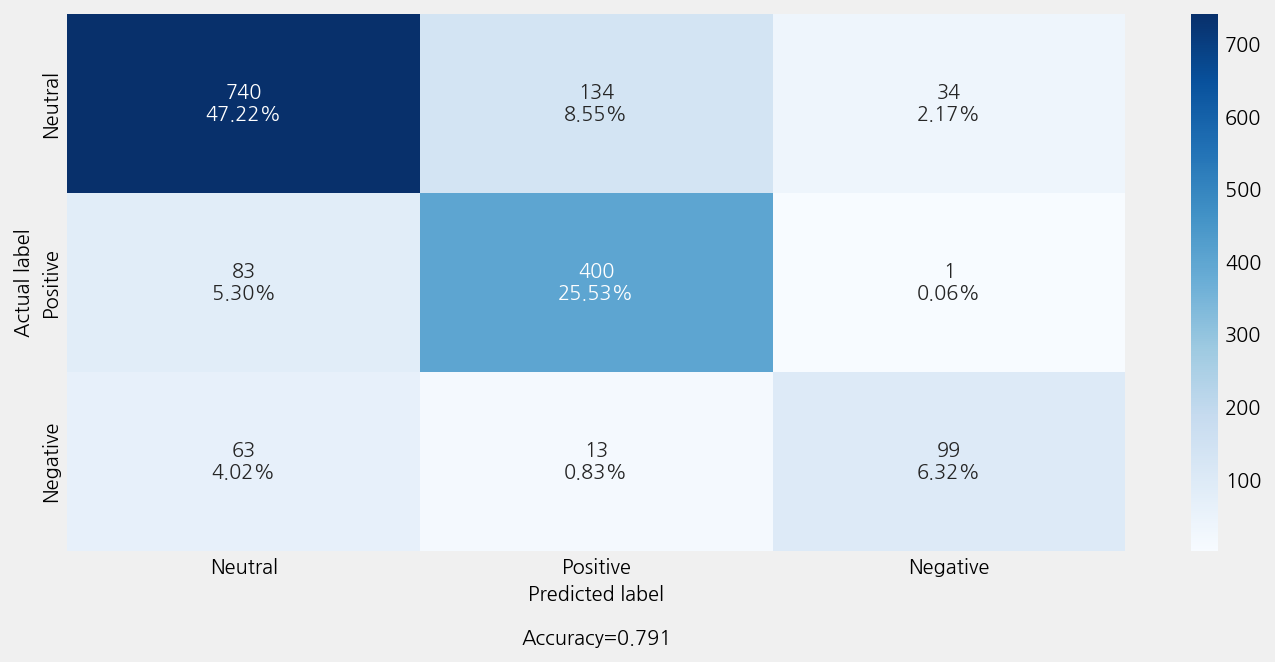

In [44]:
ds_cfg = eKonf.compose("dataset")
ds_cfg.name = "esg_cv_polarity_kr"
ds_cfg.data_dir = data_dir

overrides=[
    '+model/transformer=classification',
    '+model/transformer/pretrained=ekonelectra-base',
]
model_cfg = eKonf.compose('model/transformer=classification', overrides)
model_cfg.name = "esg_cv_polarity"
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 5
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 32
model_cfg.config.eval_batch_size = 32
model_cfg._method_ = ['train', 'eval']
model_cfg.labels = ['positive','neutral','negative']
eKonf.instantiate(model_cfg)